### This notebook runs ECMWF's aifs-ens-v1 data-driven model, using ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset and the [anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

aifs-ens-v1 is designed to be an inhererently uncertain model, meaning that for the same initial conditions, different noise is applied within the model and a different forecast will be provided. Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. Operational AIFS ENS forecast data can be found in ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset. 

# 1. Install Required Packages and Imports


In [1]:
## Uncomment the lines below to install the required packages
# !pip install torch==2.5.0 anemoi-inference[huggingface]==0.6.0 anemoi-models==0.6.0 anemoi-graphs==0.6.0 anemoi-datasets==0.5.23
#!pip install earthkit-regrid==0.4.0 'ecmwf-opendata>=0.3.19'
#!pip install flash_attn

In [33]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU device:", torch.cuda.get_device_name(0))
print("GPU count:", torch.cuda.device_count())

PyTorch version: 2.4.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA A100-SXM4-80GB
GPU count: 1


In [2]:
import datetime
from collections import defaultdict

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

from ecmwf.opendata import Client as OpendataClient

# 2. Retrieve Initial Conditions from ECMWF Open Data
## List of parameters to retrieve form ECMWF open data


In [3]:
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw"]
PARAM_SFC_FC = ["lsm", "z", "slor", "sdor"]
PARAM_SOIL =["sot"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
SOIL_LEVELS = [1,2]

## Select a date

In [4]:
DATE = OpendataClient("ecmwf").latest()
print("Initial date is", DATE)

Initial date is 2025-11-25 06:00:00


## Get the data from the ECMWF Open Data API


In [5]:
def get_open_data(param, levelist=[], number = None):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [DATE - datetime.timedelta(hours=6), DATE]:
        if number is None:
            data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        else:
            data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist, number=[number], stream='enfo')
        
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721,1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to N320
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": "N320"})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

## Get Input Fields

> Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. 

To get different ensemble initial conditions from the ifs pertubation, set `number` to an ensemble number, between 1-50.


In [6]:
fields = {}
# number = None
number = 5

### Add the single levels fields


In [7]:
fields.update(get_open_data(param=PARAM_SFC, number=number))
fields.update(get_open_data(param=PARAM_SFC_FC)) # Add constant surface fields, retrieved from fc

<multiple>:   0%|          | 0.00/5.40M [00:00<?, ?B/s]

By downloading data from the ECMWF open data dataset, you agree to the terms: Attribution 4.0 International (CC BY 4.0). Please attribute ECMWF when downloading this data.


9533e90f8433424400ab53c7fafc87ba1a04453093311c0b5bd0b35fedc1fb83.npz:   0%|          | 0.00/7.11M [00:00<?, ?B…

<multiple>:   0%|          | 0.00/5.42M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

In [8]:
soil=get_open_data(param=PARAM_SOIL,levelist=SOIL_LEVELS, number=number)

<multiple>:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Soil parameters have been renamed since training this model, we need to rename to the original names

In [9]:
mapping = {'sot_1': 'stl1', 'sot_2': 'stl2',
           'vsw_1': 'swvl1','vsw_2': 'swvl2'}
for k,v in soil.items():
    fields[mapping[k]]=v

### Add the pressure levels fields


In [10]:
fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS, number=number))

<multiple>:   0%|          | 0.00/55.7M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/56.3M [00:00<?, ?B/s]

### Convert geopotential height into geopotential

In [11]:
# Transform GH to Z
for level in LEVELS:
    gh = fields.pop(f"gh_{level}")
    fields[f"z_{level}"] = gh * 9.80665

## Create Initial State

In [12]:
input_state = dict(date=DATE, fields=fields)

# 3. Load the Model and Run the Forecast

## Download the Model's Checkpoint from Hugging Face & create a Runner


In [13]:
checkpoint = {"huggingface":"ecmwf/aifs-ens-1.0"}

To reduce the memory usage of the model certain environment variables can be set, like the number of chunks of the model's mapper. Please refer to:

https://anemoi.readthedocs.io/projects/models/en/latest/modules/layers.html#anemoi-inference-num-chunks

https://pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf

for more information. To do so, you can use the code below:

```
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True' 
os.environ['ANEMOI_INFERENCE_NUM_CHUNKS']='16'
```

In [14]:
runner = SimpleRunner(checkpoint, device="cuda")

### Run the forecast

In [15]:
for state in runner.run(input_state=input_state, lead_time=12):
    print_state(state)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]


😀 date=2025-11-25T12:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=1.28583e-06    max=3.3691e-06    
    t_1000 shape=(542080,) min=228.796        max=315.495       
    v_925  shape=(542080,) min=-32.6058       max=27.9454       
    z_850  shape=(542080,) min=8956.32        max=16397.5       
    ro     shape=(542080,) min=0              max=0.0101982     


😀 date=2025-11-25T18:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=1.27994e-06    max=3.20485e-06   
    t_1000 shape=(542080,) min=228.179        max=313.466       
    v_925  shape=(542080,) min=-31.1158       max=36.655        
    z_850  shape=(542080,) min=9260.7         max=16727.4       
    ro     shape=(542080,) min=0              max=0.0104317     



In [46]:
import copy

# Correct way to store states - make a deep copy
states = []
for state in runner.run(input_state=input_state, lead_time=60):
  print_state(state)
  states.append(copy.deepcopy(state))  # ← Important: deep copy!

print(f"\n✅ Stored {len(states)} unique states")

# Verify they're different
print("\nVerifying stored states:")
for i, s in enumerate(states):
  forecast_hour = (i + 1) * 6
  print(f"  +{forecast_hour:3d}h: {s['date']} | 100u range: [{s['fields']['100u'].min():6.2f}, {s['fields']['100u'].max():6.2f}]")


😀 date=2025-11-25T12:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=1.35377e-06    max=3.21037e-06   
    t_1000 shape=(542080,) min=228.816        max=315.523       
    v_925  shape=(542080,) min=-32.4961       max=31.2142       
    z_850  shape=(542080,) min=8832.52        max=16404.1       
    ro     shape=(542080,) min=0              max=0.00965325    


😀 date=2025-11-25T18:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=1.25511e-06    max=3.20528e-06   
    t_1000 shape=(542080,) min=228.274        max=313.368       
    v_925  shape=(542080,) min=-29.193        max=29.2928       
    z_850  shape=(542080,) min=9189.23        max=16790.5       
    ro     shape=(542080,) min=0              max=0.00922508    


😀 date=2025-11-26T00:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=1.34593e-06    max=3.2295e-06    
    t_1000 shape=(542080,) min=227.486  

# 4. Inspect the generated forecast

### Plot a field


In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

In [53]:
# Now plot a specific forecast hour
def plot_field(state, field_name, title_prefix="", cmap=None, label=None):
  """Plot a field from AIFS state"""
  def fix(lons):
      return np.where(lons > 180, lons - 360, lons)

  latitudes = state["latitudes"]
  longitudes = state["longitudes"]
  values = state["fields"][field_name]

  fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
  ax.coastlines()
  ax.add_feature(cfeature.BORDERS, linestyle=":")

  triangulation = tri.Triangulation(fix(longitudes), latitudes)

  contour = ax.tricontourf(triangulation, values, levels=20,
                           transform=ccrs.PlateCarree(), cmap=cmap )
  cbar = fig.colorbar(contour, ax=ax, orientation="vertical",
                      shrink=0.7, label=label or field_name)

  plt.title(f"{title_prefix}{field_name} at {state['date']}")
  plt.show()

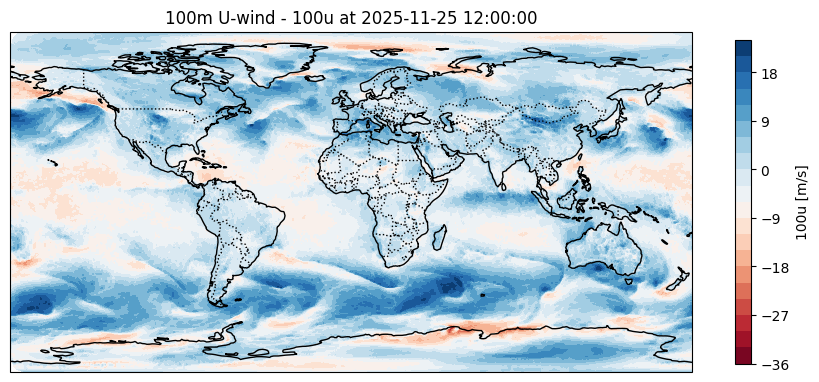

In [55]:
# Plot specific forecast hours
plot_field(states[0], "100u", "100m U-wind - ", cmap="RdBu", label="100u [m/s]")  # +6 hours
# plot_field(states[3], "100u", "100m U-wind - ", label="100u [m/s]")  # +24 hours
# plot_field(states[9], "100u", "100m U-wind - ", label="100u [m/s]")  # +60 hours

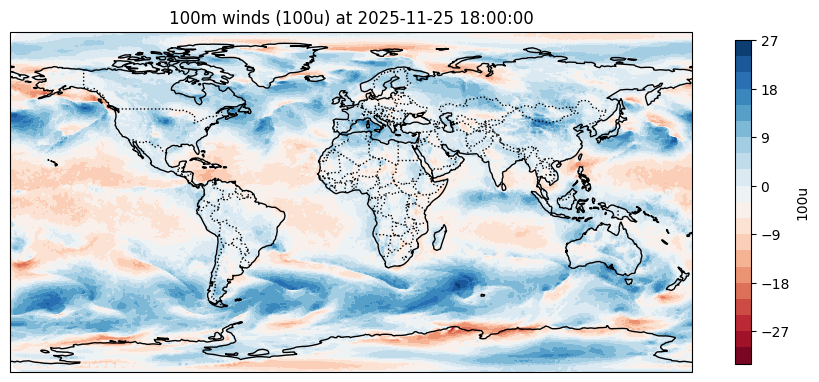

In [25]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["100u"]

fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="100u")

plt.title("100m winds (100u) at {}".format(state["date"]))
plt.show()

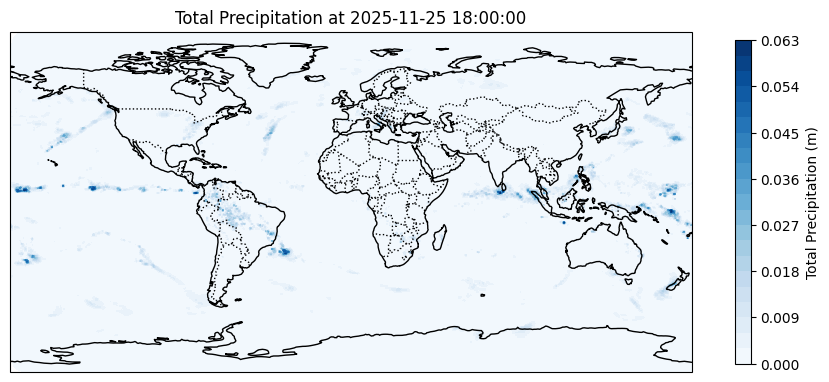

In [24]:
def fix(lons):
  # Shift the longitudes from 0-360 to -180-180
  return np.where(lons > 180, lons - 360, lons)

# Extract the data from the final state
latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["tp"]  # Total precipitation

# Create the plot
fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Create triangulation for the unstructured N320 grid
triangulation = tri.Triangulation(fix(longitudes), latitudes)

# Plot with appropriate colormap and levels for precipitation
contour = ax.tricontourf(triangulation, values, levels=20,
                        transform=ccrs.PlateCarree(), cmap="Blues")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical",
                  shrink=0.7, label="Total Precipitation (m)")

plt.title(f"Total Precipitation at {state['date']}")
plt.show()

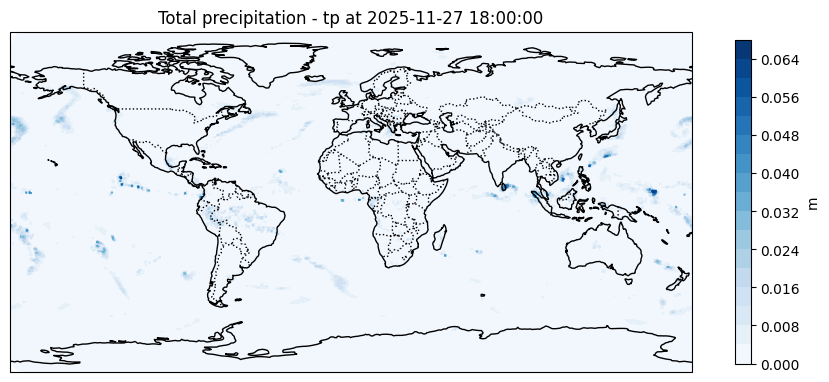

In [56]:
plot_field(states[9], "tp", "Total precipitation - ", cmap="Blues", label="m")  # +60 hours

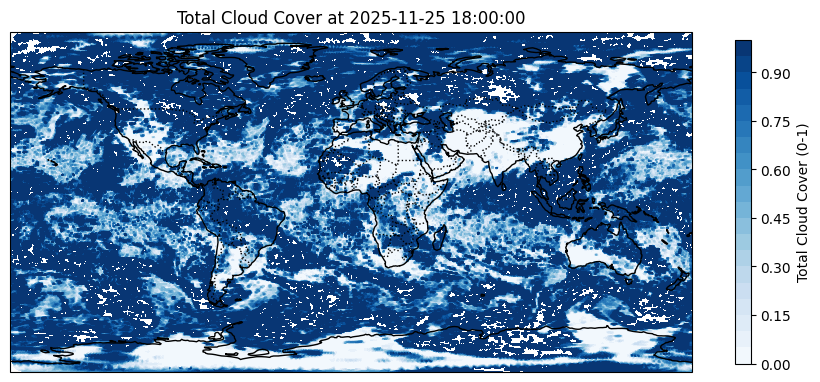

In [28]:
def fix(lons):
  # Shift the longitudes from 0-360 to -180-180
  return np.where(lons > 180, lons - 360, lons)

# Extract the data from the final state
latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["tcc"]  # Total cloud cover

# Create the plot
fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Create triangulation for the unstructured N320 grid
triangulation = tri.Triangulation(fix(longitudes), latitudes)

# Plot with appropriate colormap for cloud cover (0-1 range)
contour = ax.tricontourf(triangulation, values, levels=20,
                        transform=ccrs.PlateCarree(), cmap="Blues")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical",
                  shrink=0.7, label="Total Cloud Cover (0-1)")

plt.title(f"Total Cloud Cover at {state['date']}")
plt.show()

In [29]:
# Pressure levels from the AIFS notebook
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]

def extract_aifs_3d_data(state, param_name, pressure_levels):
  data_list = []
  for level in pressure_levels:
      field_name = f"{param_name}_{level}"
      if field_name in state["fields"]:
          data_list.append(state["fields"][field_name])
      else:
          raise ValueError(f"Field {field_name} not found in state")

  # Stack along first dimension: [n_levels, n_points]
  return np.stack(data_list, axis=0)

In [30]:
def calculate_ivt_aifs(state, pressure_levels=None, p_top=200, p_bottom=1000):

  if pressure_levels is None:
      pressure_levels = LEVELS

  g = 9.81  # m/s²

  # Filter pressure levels
  pressure_levels_filtered = [p for p in pressure_levels if p_top <= p <= p_bottom]
  pressure_levels_filtered = sorted(pressure_levels_filtered, reverse=True)  # Descending order

  if len(pressure_levels_filtered) == 0:
      raise ValueError(f"No pressure levels found between {p_top} and {p_bottom} hPa")

  print(f"Using {len(pressure_levels_filtered)} levels: {pressure_levels_filtered}")

  # Extract u, v, q data for all levels
  u_data = extract_aifs_3d_data(state, 'u', pressure_levels_filtered)  # [n_levels, n_points]
  v_data = extract_aifs_3d_data(state, 'v', pressure_levels_filtered)
  q_data = extract_aifs_3d_data(state, 'q', pressure_levels_filtered)

  n_levels = len(pressure_levels_filtered)
  n_points = u_data.shape[1]

  # Convert to torch tensors for calculation
  u_data = torch.from_numpy(u_data).float()
  v_data = torch.from_numpy(v_data).float()
  q_data = torch.from_numpy(q_data).float()

  # Convert pressure levels to Pa
  pressure_levels_pa = torch.tensor(pressure_levels_filtered, dtype=torch.float32) * 100

  # Calculate pressure layer thicknesses (dp)
  dp = torch.zeros(n_levels)
  for i in range(n_levels - 1):
      dp[i] = abs(pressure_levels_pa[i+1] - pressure_levels_pa[i])
  # Last layer: assume same thickness as previous
  dp[-1] = dp[-2] if n_levels > 1 else 5000  # 50 hPa in Pa

  # Reshape dp for broadcasting: [n_levels, 1]
  dp = dp.view(n_levels, 1)

  # Calculate moisture flux at each level
  moisture_flux_u = q_data * u_data  # [n_levels, n_points]
  moisture_flux_v = q_data * v_data

  # Integrate vertically: IVT = (1/g) * Σ(q*V*dp)
  ivt_u = torch.sum(moisture_flux_u * dp, dim=0) / g  # [n_points]
  ivt_v = torch.sum(moisture_flux_v * dp, dim=0) / g

  # Calculate IVT magnitude
  ivt_magnitude = torch.sqrt(ivt_u**2 + ivt_v**2)

  # Convert back to numpy
  return ivt_u.numpy(), ivt_v.numpy(), ivt_magnitude.numpy()

In [41]:
def plot_ivt(state, ivt_magnitude, ivt_u=None, ivt_v=None, 
           threshold=250, arrow_density=20):
  def fix(lons):
      return np.where(lons > 180, lons - 360, lons)

  latitudes = state["latitudes"]
  longitudes = fix(state["longitudes"])

  fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})
  ax.coastlines()
  ax.add_feature(cfeature.BORDERS, linestyle=":")
  ax.add_feature(cfeature.LAND, alpha=0.1)

  # Create triangulation
  triangulation = tri.Triangulation(longitudes, latitudes)

  # Plot IVT magnitude
  levels = np.linspace(0, 800, 17)  # 0 to 800 kg/(m·s)
  contour = ax.tricontourf(triangulation, ivt_magnitude, levels=levels,
                            transform=ccrs.PlateCarree(), cmap="YlGnBu", extend='max')

  # Add AR threshold contour
  if threshold:
      ax.tricontour(triangulation, ivt_magnitude, levels=[threshold],
                   colors='red', linewidths=2, transform=ccrs.PlateCarree())

  cbar = fig.colorbar(contour, ax=ax, orientation="horizontal",
                      pad=0.05, label="IVT Magnitude [kg/(m·s)]")

  plt.title(f"Integrated Vapor Transport at {state['date']}\n"
            f"(Red contour: AR threshold = {threshold} kg/(m·s))")
  plt.tight_layout()
  plt.show()

In [57]:
# Calculate IVT for all states
print("Calculating IVT for all forecast times...")
ivt_data = []

for i, state in enumerate(states):
  forecast_hour = (i + 1) * 6
  print(f"  Computing IVT for +{forecast_hour}h...")

  ivt_u, ivt_v, ivt_mag = calculate_ivt_aifs(state, p_top=200, p_bottom=1000)

  ivt_data.append({
      # 'ivt_u': ivt_u,
      # 'ivt_v': ivt_v,
      'ivt_magnitude': ivt_mag,
      'forecast_hour': forecast_hour
  })

print(f"\n✅ IVT calculated for all {len(ivt_data)} states")

Calculating IVT for all forecast times...
  Computing IVT for +6h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +12h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +18h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +24h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +30h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +36h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +42h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +48h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +54h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
  Computing IVT for +60h...
Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300,

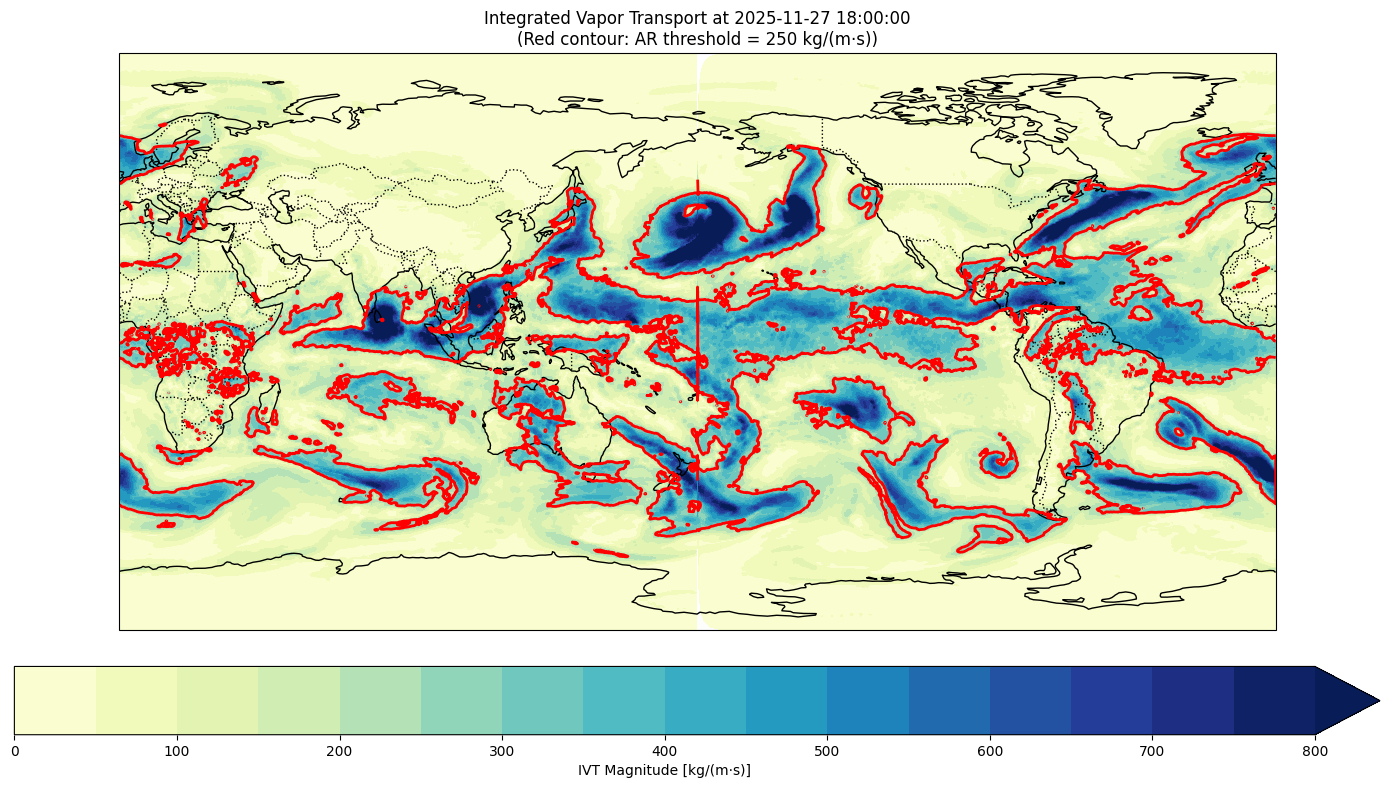

In [59]:
plot_ivt(states[9], ivt_data[9]['ivt_magnitude'])  # +60h

Using 10 levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200]
IVT magnitude range: 0.0 to 1482.6 kg/(m·s)
Mean IVT: 193.5 kg/(m·s)


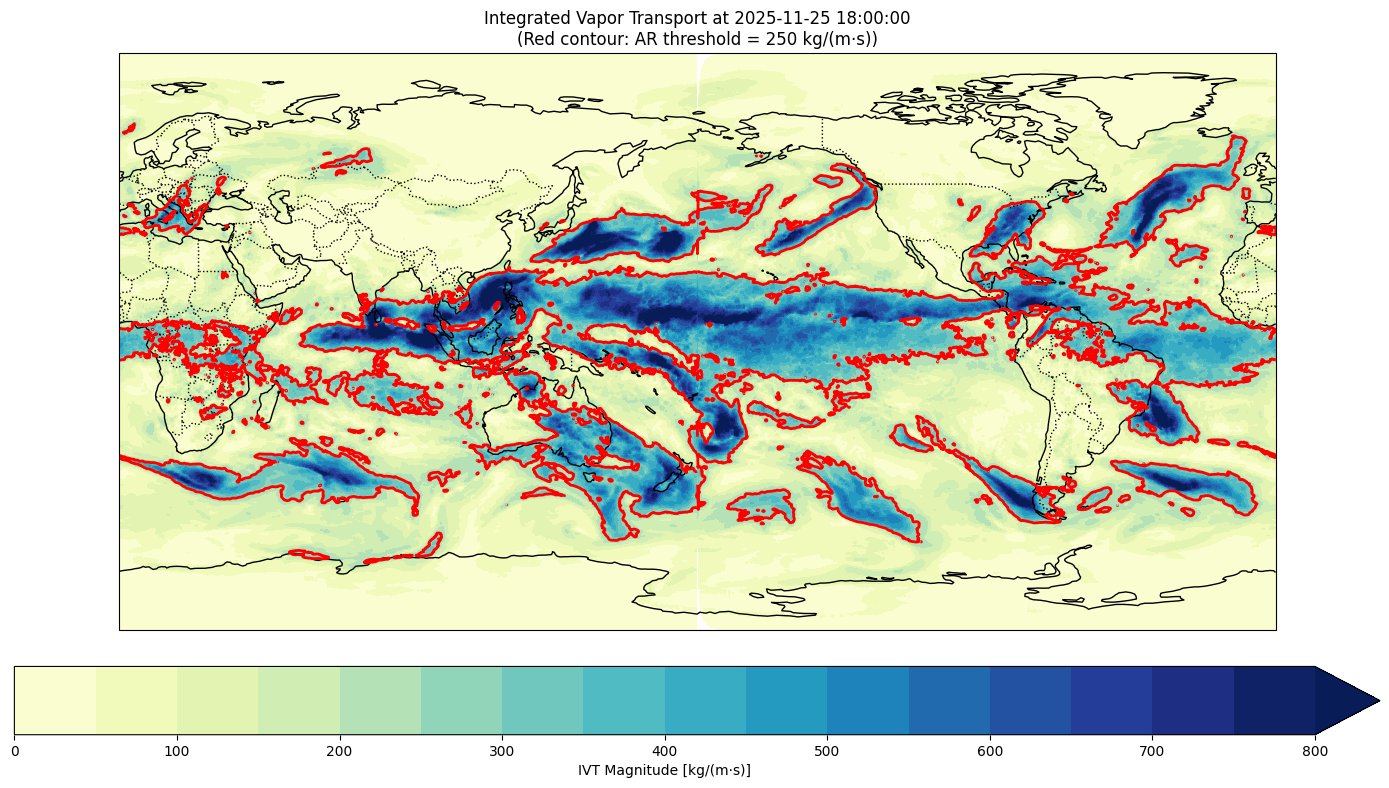

In [42]:
# Calculate IVT using 200-1000 hPa levels
ivt_u, ivt_v, ivt_magnitude = calculate_ivt_aifs(state, p_top=200, p_bottom=1000)

print(f"IVT magnitude range: {ivt_magnitude.min():.1f} to {ivt_magnitude.max():.1f} kg/(m·s)")
print(f"Mean IVT: {ivt_magnitude.mean():.1f} kg/(m·s)")

# Plot IVT magnitude with AR threshold
plot_ivt(state, ivt_magnitude, ivt_u, ivt_v, threshold=250, arrow_density=30)